In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import SimpleITK as sitk
import mahotas as mt

from matplotlib.patches import Rectangle
from scipy import linalg
from skimage.util.shape import view_as_windows
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product
from eolearn.features.haralick import HaralickTask
from eolearn.core import EOPatch
from skimage.feature.texture import greycomatrix

In [2]:
# Read image
img_s = sitk.ReadImage('../sample_data/ImageSlice.png')
img_array = sitk.GetArrayFromImage(img_s)
img_array = img_array[:,:,0]
print(f'IMAGE:\nwidth={img_array.shape[1]} height={img_array.shape[0]}')

IMAGE:
width=596 height=440


In [3]:
# Create random window.
svd_radius = 5
patch_window_width = 30
patch_window_height = 30
mask_min_x = 252
mask_min_y = 193
mask_max_x = mask_min_x + patch_window_width
mask_max_y = mask_min_y + patch_window_height

In [4]:
def show_colored_image(figure, axis, image_data, colormap=plt.cm.jet):
    image = axis.imshow(image_data, cmap=colormap)
    divider = make_axes_locatable(axis)
    colorbar_axis = divider.append_axes("right", size="5%", pad=0.05)
    figure.colorbar(image, cax=colorbar_axis)

def create_highlighted_rectangle(x, y, w, h):
    return Rectangle((x, y), w, h, linewidth=3, edgecolor='cyan', facecolor='none')

def highlight_rectangle_on_image(image_data, min_x, min_y, w, h, colormap=plt.cm.gray):
    figure, axes = plt.subplots(1,2, figsize=(15,15))

    # Highlight window within image.
    show_colored_image(figure, axes[0], image_data, colormap)
    axes[0].add_patch(create_highlighted_rectangle(min_x, min_y, w, h))

    # Crop window.
    cropped_array = image_data[min_y:min_y+h, min_x:min_x+w]
    axes[1].set_title(f'Cropped Region ({w}x{h})')
    show_colored_image(figure, axes[1], cropped_array, colormap)
    
    plt.show()
    
    return cropped_array

In [5]:
# Extend outwards
padded_mask_min_x = max(mask_min_x - svd_radius, 0)
padded_mask_min_y = max(mask_min_y - svd_radius, 0)
padded_mask_max_x = min(mask_max_x + svd_radius, img_array.shape[1]-1)
padded_mask_max_y = min(mask_max_y + svd_radius, img_array.shape[0]-1)
print(f'x = {padded_mask_min_x}:{padded_mask_max_x} ({padded_mask_max_x - padded_mask_min_x})')
print(f'y = {padded_mask_min_y}:{padded_mask_max_y} ({padded_mask_max_y - padded_mask_min_y})')
padded_cropped_array = img_array[padded_mask_min_y:padded_mask_max_y, padded_mask_min_x:padded_mask_max_x]
print(padded_cropped_array.shape)

x = 247:287 (40)
y = 188:228 (40)
(40, 40)


In [6]:
# Calculate gradient
rescaled_padded_cropped_array = padded_cropped_array/256
dx=np.gradient(rescaled_padded_cropped_array, axis=1)
dy=np.gradient(rescaled_padded_cropped_array, axis=0)


In [7]:
# def svd_dominant_angle(center_x, center_y, dx_windows, dy_windows):
def svd_dominant_angle(x, y, dx_windows, dy_windows):
    dx_patch = dx_windows[y, x]
    dy_patch = dy_windows[y, x]
    
    window_area = dx_patch.size
    flattened_gradients = np.zeros((window_area, 2))
    flattened_gradients[:,0] = np.reshape(dx_patch, ((window_area)), order='F')
    flattened_gradients[:,1] = np.reshape(dy_patch, ((window_area)), order='F')
    
    U, S, V = linalg.svd(flattened_gradients)
    dominant_angle = math.atan2(V[0, 0], V[1, 0])
    
    return dominant_angle

In [8]:
# loop through all regions and calculate dominant angles

dominant_angles_array = np.zeros((patch_window_height,patch_window_width), np.single)

print(f'dx shape = {dx.shape}')
print(f'dominant angles shape = {dominant_angles_array.shape}')

svd_diameter = svd_radius*2+1
dx_windows = view_as_windows(dx, (svd_diameter, svd_diameter))
dy_windows = view_as_windows(dy, (svd_diameter, svd_diameter))

print(f'svd radius = {svd_radius}')
print(f'svd diameter = {svd_diameter}')
print(f'dx windows shape = {dx_windows.shape}')

center_x_range = range(dx_windows.shape[1])
center_y_range = range(dx_windows.shape[0])

print(f'{center_x_range}, {center_y_range}')
for current_svd_center_x in center_x_range:
    for current_svd_center_y in center_y_range:
        current_dominant_angle = svd_dominant_angle(
            current_svd_center_x, current_svd_center_y,
            dx_windows, dy_windows)
        dominant_angles_array[current_svd_center_y, current_svd_center_x] = current_dominant_angle
        if (random.randint(0,500)==0):
            print(f'x={current_svd_center_x}, y={current_svd_center_y}')
            print(f'angle={current_dominant_angle}')
print('Done calculating dominant angles.')

dx shape = (40, 40)
dominant angles shape = (30, 30)
svd radius = 5
svd diameter = 11
dx windows shape = (30, 30, 11, 11)
range(0, 30), range(0, 30)
Done calculating dominant angles.


In [9]:
def get_haralick_mt_value(img_array, center_x, center_y, window_size, greylevels, haralick_feature, symmetric, mean):
    
    # extract subpart of image (todo: pass in result from view_as_windows)
    min_x = int(max(0, center_x - window_size / 2 - 1))
    min_y = int(max(0, center_y - window_size / 2 - 1))
    max_x = int(min(img_array.shape[1] - 1, center_x + window_size / 2 + 1))
    max_y = int(min(img_array.shape[0] - 1, center_y + window_size / 2 + 1))
    cropped_img_array = img_array[min_y:max_y, min_x:max_x]
    
    # co-occurence matrix of all 8 directions and sum them
    cmat = greycomatrix(cropped_img_array, [1], [0, 1*np.pi/4, 2*np.pi/4, 3*np.pi/4, 4*np.pi/4, 5*np.pi/4, 6*np.pi/4, 7*np.pi/4], levels=greylevels)
    cmat = np.sum(cmat, axis=3);
    cmat = cmat[:,:,0]
    
    # extract haralick using mahotas library:
    har_feature = mt.features.texture.haralick_features([cmat], return_mean=mean)
    
    # output:
    if mean:
        return har_feature[haralick_feature]
    return har_feature[direction, haralick_feature]

In [10]:
def get_haralick_mt_feature(img, desired_haralick_feature, greylevels, haralick_window_size, symmetric=False, mean=False):
    haralick_image = np.zeros(img.shape)
    h, w = img.shape
    for pos in product(range(w), range(h)):
       result = get_haralick_mt_value(img, pos[0], pos[1], haralick_window_size, greylevels, desired_haralick_feature, symmetric, mean)
       haralick_image[pos[1], pos[0]] = result
    return haralick_image

In [11]:
# Rescale the range of the pixels to have discrete grey level values
greylevels = 64

new_max = greylevels-1
new_min = 0

dominant_angles_max = dominant_angles_array.max()
dominant_angles_min = dominant_angles_array.min()

dominant_angles_shaped = (dominant_angles_array - dominant_angles_min) / (dominant_angles_max - dominant_angles_min)
dominant_angles_shaped = dominant_angles_shaped * (new_max - new_min) + new_min
dominant_angles_shaped = np.round(dominant_angles_shaped)
dominant_angles_shaped = dominant_angles_shaped.astype(int)

In [12]:
# Calculate haralick
haralick_window_size = svd_radius * 2 + 1

haralick_features = np.empty((patch_window_height, patch_window_width, 13))

for feature in range(13):
    print(f'Calculating feature {feature+1}:')
    haralick_features[:,:,feature] = get_haralick_mt_feature(dominant_angles_shaped, feature, greylevels, haralick_window_size, symmetric=False, mean=True)
    print('Calculated.')

Calculating feature 1:
Calculated.
Calculating feature 2:
Calculated.
Calculating feature 3:
Calculated.
Calculating feature 4:
Calculated.
Calculating feature 5:
Calculated.
Calculating feature 6:
Calculated.
Calculating feature 7:
Calculated.
Calculating feature 8:
Calculated.
Calculating feature 9:
Calculated.
Calculating feature 10:
Calculated.
Calculating feature 11:
Calculated.
Calculating feature 12:
Calculated.
Calculating feature 13:
Calculated.


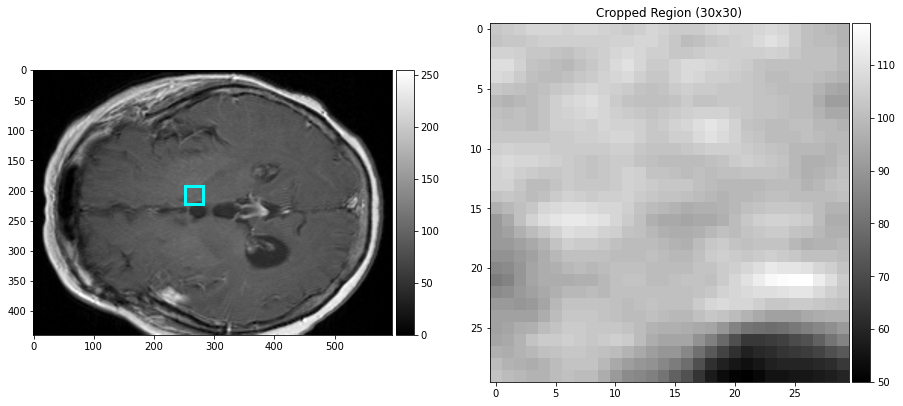

(30, 30)


In [13]:
# Display patch
print(highlight_rectangle_on_image(img_array, mask_min_x, mask_min_y, patch_window_width, patch_window_height).shape)

Text(0.5, 1.0, 'Gy size=(40, 40)')

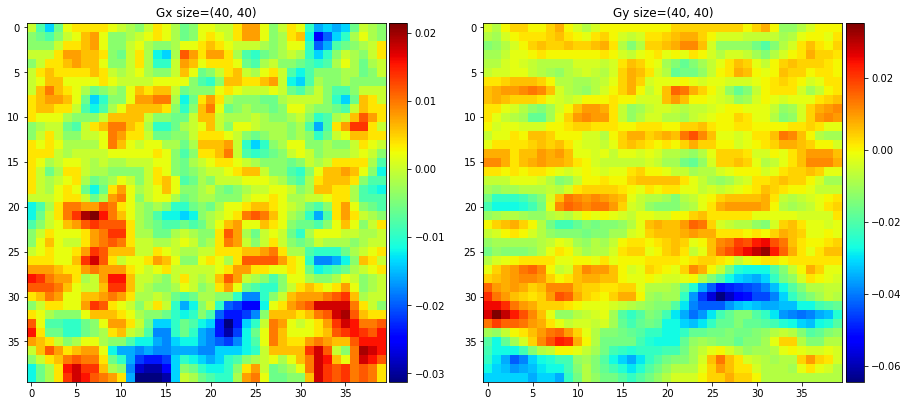

In [14]:
# Display gradient
figure, axes = plt.subplots(1, 2, figsize=(15, 15))
show_colored_image(figure, axes[0], dx)
axes[0].set_title(f'Gx size={dx.shape}')
show_colored_image(figure, axes[1], dy)
axes[1].set_title(f'Gy size={dy.shape}')

Text(0.5, 1.0, 'Dominant Angles (Color Binned)')

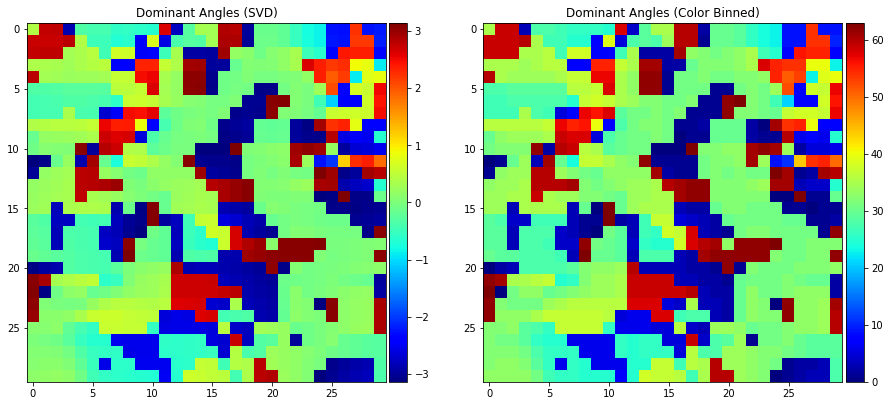

In [15]:
# Display dominant angles
figure, axes = plt.subplots(1, 2, figsize=(15, 15))
show_colored_image(figure, axes[0], dominant_angles_array)
axes[0].set_title('Dominant Angles (SVD)')
show_colored_image(figure, axes[1], dominant_angles_shaped)
axes[1].set_title('Dominant Angles (Color Binned)')

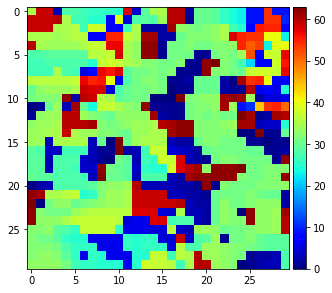

In [16]:

# Display dominant angles color-binned
figure, axis = plt.subplots(1,1, figsize=(5,5))
show_colored_image(figure, axis, dominant_angles_shaped)

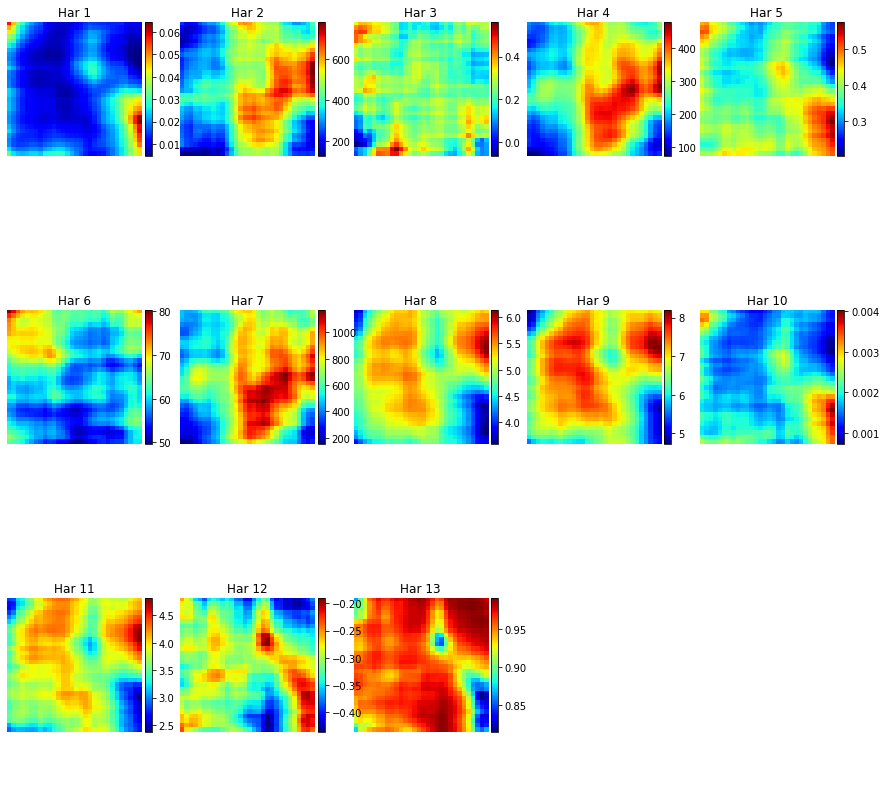

In [17]:
# Display haralick
figure, axes = plt.subplots(3, 5, figsize=(15,15))

for row in range(3):
    for col in range(5):
        feature = row*5+col
        axis = axes[row][col]
        axis.set_axis_off()
        if feature>=13:
            continue
        show_colored_image(figure, axis, haralick_features[:,:,feature])
        axis.set_title(f'Har {feature+1}')